# Onset asynchrony

## Import dependencies, set constants etc.

In [44]:
from itertools import pairwise

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal
import seaborn as sns

from src import utils
import src.visualise.visualise_utils as vutils

## Load in data
We need to unserialise our list of onsets first

In [2]:
onsets: list = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

## Get position of marked beats
Now we can iterate through successive downbeats in a performance and express the position of each marked beat proportionally.

In [52]:
asynchronies = []
# Iterate over every track
for num, track in enumerate(onsets, 1):
    print(f'{num} / {len(onsets)}')
    if track.item['time_signature'] == 3:
        continue
    bandleader = track.item['pianist']
    temp = pd.DataFrame(track.summary_dict)
    idx = temp[temp['metre_manual'] == 1].index
    # Iterate through successive downbeats
    for downbeat1, downbeat2 in pairwise(idx):
        # Get all the beats marked between our two downbeats (beat 1 bar 1, beat 1 bar 2)
        bw = temp[(downbeat1 <= temp.index) & (temp.index < downbeat2)]
        sub = bw[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
        # Get the first downbeat of the first bar, and the last downbeat of the second
        first, last = temp[temp.index == downbeat1]['beats'].iloc[0], temp[temp.index == downbeat2]['beats'].iloc[0]
        # Scale our onsets to be proportional with our first and last values
        prop = (sub - first) / (last - first)
        # Drop values after 1/16th note or before 1/32nd note
        upper_bound = (((bw['metre_manual'] - 1) * 1/4) + 1/16)
        lower_bound = ((bw['metre_manual'] - 1) * 1/4) - 1/32
        for col in prop.columns:
            prop[col][(prop[col] < lower_bound) | (prop[col] > upper_bound)] = np.nan
        # Convert values to degrees
        prop *= 360
        prop = pd.concat([prop, bw['metre_manual']], axis=1)
        # Iterate through each column and add values to our list
        for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
            for _, val in prop[[instr, 'metre_manual']].dropna().iterrows():
                asynchronies.append(dict(instr=instr, asynchrony=val[instr], beat=val['metre_manual'], bandleader=bandleader))
df = pd.DataFrame(asynchronies)

1 / 300
2 / 300
3 / 300
4 / 300
5 / 300
6 / 300
7 / 300
8 / 300
9 / 300
10 / 300
11 / 300
12 / 300
13 / 300
14 / 300
15 / 300
16 / 300
17 / 300
18 / 300
19 / 300
20 / 300
21 / 300
22 / 300
23 / 300
24 / 300
25 / 300
26 / 300
27 / 300
28 / 300
29 / 300
30 / 300
31 / 300
32 / 300
33 / 300
34 / 300
35 / 300
36 / 300
37 / 300
38 / 300
39 / 300
40 / 300
41 / 300
42 / 300
43 / 300
44 / 300
45 / 300
46 / 300
47 / 300
48 / 300
49 / 300
50 / 300
51 / 300
52 / 300
53 / 300
54 / 300
55 / 300
56 / 300
57 / 300
58 / 300
59 / 300
60 / 300
61 / 300
62 / 300
63 / 300
64 / 300
65 / 300
66 / 300
67 / 300
68 / 300
69 / 300
70 / 300
71 / 300
72 / 300
73 / 300
74 / 300
75 / 300
76 / 300
77 / 300
78 / 300
79 / 300
80 / 300
81 / 300
82 / 300
83 / 300
84 / 300
85 / 300
86 / 300
87 / 300
88 / 300
89 / 300
90 / 300
91 / 300
92 / 300
93 / 300
94 / 300
95 / 300
96 / 300
97 / 300
98 / 300
99 / 300
100 / 300
101 / 300
102 / 300
103 / 300
104 / 300
105 / 300
106 / 300
107 / 300
108 / 300
109 / 300
110 / 300
111 / 30

In [53]:
df = (
    df.set_index('instr')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

## Offset beats by drummer mean beat 1

In [254]:
df['asynchrony_offset'] = df['asynchrony'] - df[(df['instr'] == 'drums') & (df['beat'] == 1)]['asynchrony'].mean()

## Create circular plot of asynchrony by beat number

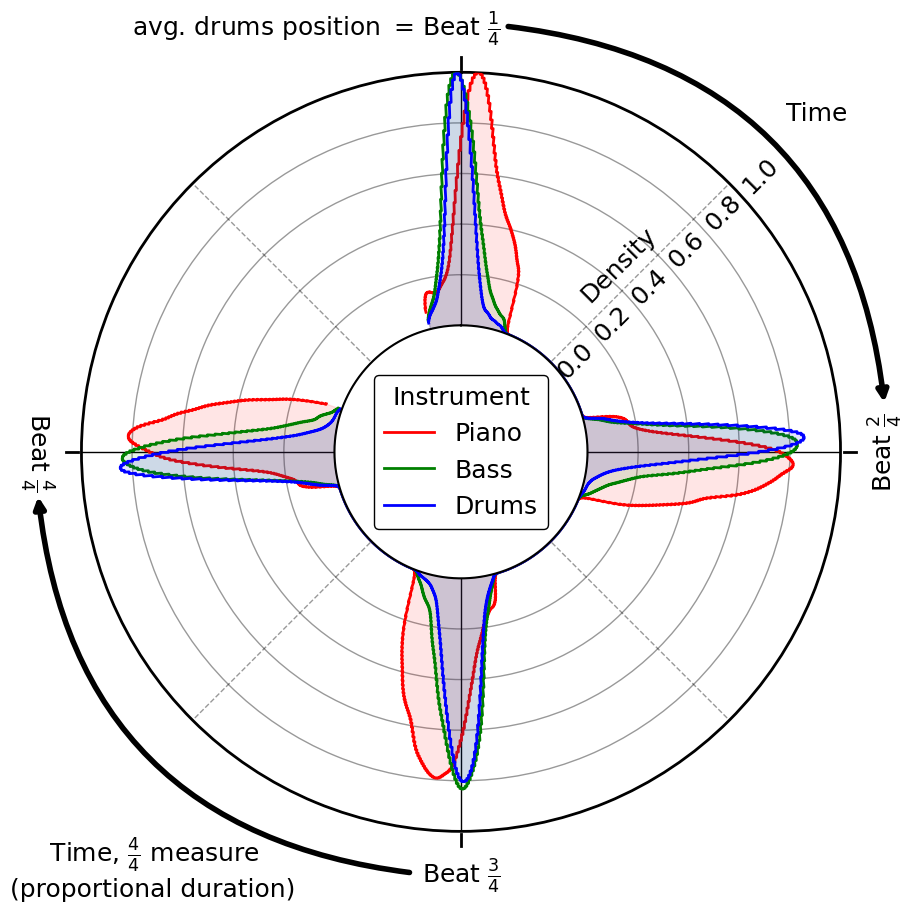

In [276]:
class PolarPlotAsynchrony(vutils.BasePlot):
    KDE_BANDWIDTH = 0.0095
    FILL_KWS = dict(step='pre', alpha=0.1, zorder=3,)
    LINE_KWS = dict(drawstyle='steps-pre', linestyle=vutils.LINESTYLE, linewidth=vutils.LINEWIDTH, zorder=3)
    ARROW_KWS = dict(
        coordsA='figure fraction', coordsB='figure fraction', arrowstyle="-|>", color=vutils.BLACK,
        connectionstyle=f"arc3,rad=-{np.radians(22.5)}", linewidth=vutils.LINEWIDTH * 2,
        linestyle=vutils.LINESTYLE, mutation_scale=16
    )
    CIRCLE_FILL_KWS = dict(fc=vutils.WHITE, zorder=5, linewidth=vutils.LINEWIDTH)
    CIRCLE_LINE_KWS = dict(zorder=10, color=vutils.BLACK, markerfacecolor=vutils.WHITE, markersize=1/10)
    CIRCLE_PADDING = 0.5
    CIRCLE_PADDING_RANGE = range(int(CIRCLE_PADDING * 10), int((CIRCLE_PADDING * 10) + 12), 2)

    def __init__(self, async_df: pd.DataFrame, **kwargs):
        """Called when initialising the class"""
        self.corpus_title = 'corpus_chronology'
        # Initialise the base plot with our given kwargs
        super().__init__(figure_title=fr'asynchrony_plots\polarplot_asynchrony_{self.corpus_title}', **kwargs)
        self.fig, self.ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))
        self.df = async_df

    def _kde(self, data, len_data: int = 1000):
        # Fit the actual KDE to the data, using the default parameters
        kde = stats.gaussian_kde(data.T, bw_method=self.KDE_BANDWIDTH)
        # Create a linear space of integers ranging from our lowest to our highest BUR
        data_plot = np.linspace(data.min(), data.max(), len_data)[:, np.newaxis]
        # Evaluate the KDE on our linear space of integers
        y = kde.evaluate(data_plot.T)
        return data_plot, np.array([(y_ - min(y)) / (max(y) - min(y)) for y_ in y])

    def _create_plot(self):
        for col, (idx, grp) in zip(vutils.RGB, self.df.groupby('instr', sort=False)):
            x, y = self._kde(grp['asynchrony_offset'].values)
            y += self.CIRCLE_PADDING
            x = np.radians(x).T[0]
            self.ax.plot(x, y, color=col, label=idx.title(), **self.LINE_KWS)
            self.ax.fill_between(x, y, color=col, **self.FILL_KWS)

    def _add_center_circle(self):
        # Plot a filled circle at the center with a larger z-order
        ls = np.linspace(0, 2 * np.pi, 10000)
        self.ax.fill_between(ls, 0, self.CIRCLE_PADDING, **self.CIRCLE_FILL_KWS)
        self.ax.plot(ls, np.full_like(ls, self.CIRCLE_PADDING), **self.CIRCLE_LINE_KWS)

    def _format_ticks(self):
        rm = self.ax.get_rmax()
        for t, i, r, in zip(np.deg2rad(np.arange(0, 360, 90)), range(1, 5), [0, 90, 0, 270],):
            self.ax.plot([t, t], [rm, self.CIRCLE_PADDING], color=vutils.BLACK, lw=vutils.LINEWIDTH / 2, ls=vutils.LINESTYLE, zorder=0)
            self.ax.plot([t, t], [rm * 0.96, rm * 0.99], clip_on=False, color=vutils.BLACK, lw=vutils.LINEWIDTH)
            self.ax.text(t, rm + 0.1, rf'Beat $\frac{{{i}}}{{4}}$', ha='center', va='center', rotation=r)
            t += np.radians(45)
            self.ax.plot([t, t], [rm, self.CIRCLE_PADDING], color=vutils.BLACK, alpha=vutils.ALPHA, lw=vutils.LINEWIDTH / 2, ls='--', zorder=0)

    def _format_ax(self):
        self._add_center_circle()
        self._format_ticks()
        self.ax.set(xticks=np.radians([0, 90, 180, 270]), xticklabels=['' for _ in range(1, 5)], rlim=(0, 1))
        self.ax.xaxis.grid(False)
        self.ax.yaxis.grid(True, **vutils.GRID_KWS)
        self.ax.set_theta_zero_location('N')
        self.ax.set_theta_direction(-1)
        self.ax.set_rticks([i / 10 for i in self.CIRCLE_PADDING_RANGE], labels=[])
        self.ax.legend(loc='center', title='Instrument', frameon=True, framealpha=1, edgecolor=vutils.BLACK)
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH)
        self.ax.text(np.radians(37.5), 0.75, 'Density', rotation=45)
        for i in self.CIRCLE_PADDING_RANGE:
            i /= 10
            self.ax.text(np.radians(45), i * 1.03, round(i - self.CIRCLE_PADDING, 1), ha='left', va='center', rotation=45)

    def _format_fig(self):
        # Use ax.transData.transform to convert fractions to figure coordinates
        # Create the ConnectionPatch with figure coordinates
        for xyA, xyB in zip([(0.555, 0.95), (0.45, 0.05)], [(0.955, 0.55), (0.055, 0.45)]):
            curved_line = mpl.patches.ConnectionPatch(xyA=xyA, xyB=xyB, **self.ARROW_KWS)
            self.ax.add_artist(curved_line)
        self.fig.text(0.85, 0.85, 'Time')
        self.fig.text(0.155, 0.9415, 'avg. drums position $=$')
        st = r'     Time, $\frac{4}{4}$ measure' \
             '\n(proportional duration)'
        self.fig.text(0.025, 0.025, st)
        self.fig.tight_layout()

PolarPlotAsynchrony(df).create_plot()
plt.show()

## Bootstrap peaks in KDE

In [256]:
df['asynchrony_adjusted'] = (df['asynchrony'] / 360) - ((df['beat'] - 1) * 1/4)
df['asynchrony_adjusted_offset'] = (df['asynchrony_offset'] / 360) - ((df['beat'] - 1) * 1/4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


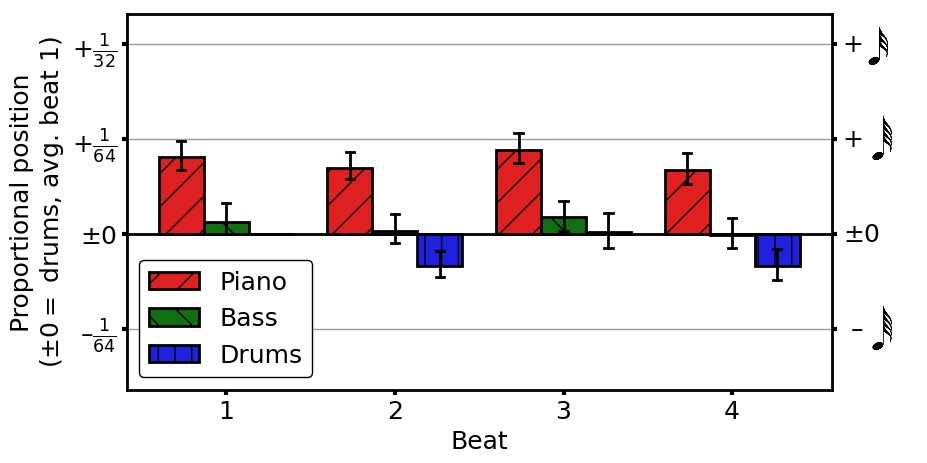

In [311]:
class BarPlotProportionalAsynchrony(vutils.BasePlot):
    BAR_KWS = dict(
        dodge=True, errorbar=None, width=0.8, estimator=np.mean,
        zorder=5, hue_order=utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(),
    )
    ERROR_KWS = dict(zorder=15, color=vutils.BLACK, ls=vutils.LINESTYLE, lw=vutils.LINEWIDTH)

    def __init__(self, async_df: pd.DataFrame, **kwargs):
        """Called when initialising the class"""
        self.corpus_title = 'corpus_chronology'
        # Initialise the base plot with our given kwargs
        super().__init__(figure_title=fr'asynchrony_plots\barplot_asynchrony_{self.corpus_title}', **kwargs)
        self.df = async_df
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 4))

    def _bootstrap(self):
        for_boot = self.df.groupby(['bandleader', 'instr', 'beat']).mean().reset_index(drop=False)
        for i in range(vutils.N_BOOT):
            print(i)
            # Shuffle the dataset
            sample = for_boot.sample(frac=1, replace=True, random_state=i)
            # Get the value required to shift drummers onto the mean
            shift_value = sample[(sample['instr'] == 'drums') & (sample['beat'] == 1)]['asynchrony_adjusted'].mean()
            # Shift the whole sample
            sample['asynchrony_shifted'] = sample['asynchrony_adjusted'] - shift_value
            # Iterate through each instrument and beat in this shuffled combination
            for i_, grp in sample.groupby(['instr', 'beat'], sort=False):
                # Get the mean value over all bandleaders and yield as a dictionary
                boot_mean = grp['asynchrony_shifted'].mean()
                yield dict(instr=i_[0], beat=i_[1] - 1, mean=boot_mean)

    def _create_plot(self):
        g = sns.barplot(
            data=self.df, x='beat', y='asynchrony_adjusted_offset', hue='instr', ax=self.ax, palette=vutils.RGB,
            ec=vutils.BLACK, ls=vutils.LINESTYLE, lw=vutils.LINEWIDTH, alpha=1, **self.BAR_KWS
        )
        self._bootstrap_errorbars()

    def _bootstrap_errorbars(self):
        bootstrap_df = (
            pd.DataFrame(self._bootstrap())
            .groupby(['instr', 'beat'], sort=False)
            .agg(dict(mean=[lambda x_: np.percentile(x_, 2.5), lambda x_: np.percentile(x_, 97.5)]))
            .reset_index(drop=False)
            .set_index('instr')
            .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
            .reset_index(drop=False)
        )
        bootstrap_df.columns = ['instr', 'beat', 'low', 'high']
        for (idx_, grp_), cont, ran in zip(bootstrap_df.groupby('instr', sort=False), self.ax.containers, range(0, 3)):
            for (idx__, grp__), rect in zip(grp_.groupby('beat'), cont.patches):
                rect.set_hatch(vutils.HATCHES[ran])
                if idx_ == 'drums' and idx__ == 0:
                    continue
                x = rect.xy[0] + 0.1333333
                self.ax.plot((x, x), (grp__['low'], grp__['high']), **self.ERROR_KWS)
                for i in ['low', 'high']:
                    self.ax.plot((x - 0.025, x + 0.025), (grp__[i], grp__[i]), **self.ERROR_KWS)

    def _format_ax(self):
        self.ax.set(
            ylim=(-1/64 - 0.01, 1/32 + 0.005), xticklabels=[1, 2, 3, 4], xlabel='Beat',
            ylabel='Proportional position\n($\pm0=$ drums, avg. beat 1)', yticks=[-1/64, 0, 1/64, 1/32],
            yticklabels=[r'–$\frac{1}{64}$', r'$\pm$0', r'+$\frac{1}{64}$', r'+$\frac{1}{32}$']
        )
        hand, _ = self.ax.get_legend_handles_labels()
        self.ax.legend(
            hand, ['Piano', 'Bass', 'Drums'], loc='lower left', title='',
            frameon=True, framealpha=1, edgecolor=vutils.BLACK
        )
        for item in self.ax.get_legend().legend_handles:
            item.set_edgecolor('black')
            item.set_linewidth(vutils.LINEWIDTH)
        self.ax.text(3.875, 0, r'$\pm$0', ha='right', va='center', clip_on=False, zorder=1000)
        for pict, v in zip(self._add_notation_vals(), ['–', '+', '+']):
            self.ax.text(pict.xy[0] - 0.1, pict.xy[1], v, ha='right', va='center', clip_on=False, zorder=1000)
            self.ax.add_artist(pict)
        self.ax.yaxis.grid(True, zorder=0, **vutils.GRID_KWS)
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH)
        self.ax.tick_params(axis='both', bottom=True, right=True, width=vutils.TICKWIDTH)
        self.ax.axhline(0, 0, 3, color=vutils.BLACK, lw=vutils.LINEWIDTH, ls=vutils.LINESTYLE)

    @staticmethod
    def _add_notation_vals():
        for val in [-64, 32, 64]:
            try:
                img = plt.imread(fr'{utils.get_project_root()}\references\images\notation\notation_{abs(val)}.png')
            except FileNotFoundError:
                pass
            # If we can get the image, then yield it to add to our plot
            else:
                yield mpl.offsetbox.AnnotationBbox(
                    mpl.offsetbox.OffsetImage(img, clip_on=False, zoom=0.15), (3.875, 1/val),
                    frameon=False, xycoords='data', clip_on=False, annotation_clip=False
                 )

    def _format_fig(self):
        self.fig.subplots_adjust(right=0.9, top=0.95, bottom=0.15, left=0.15)

BarPlotProportionalAsynchrony(df).create_plot()

## Plot histogram of beat distribution

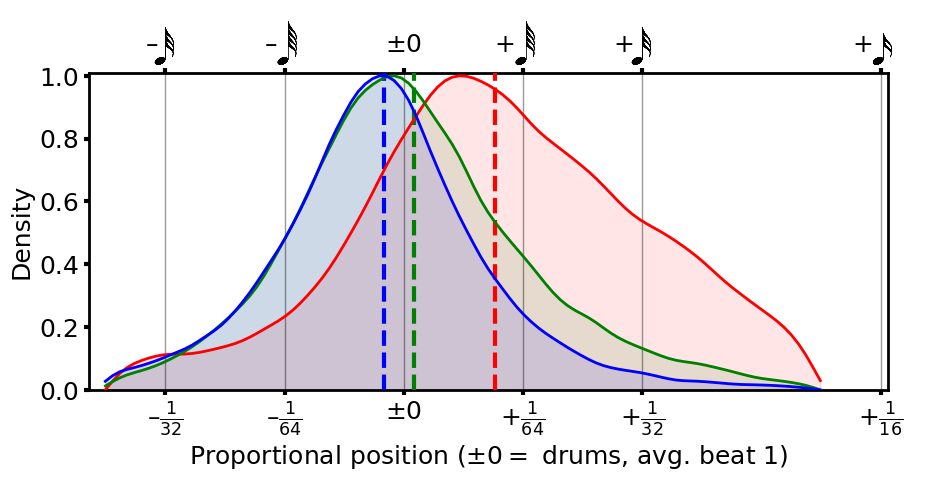

In [282]:
class HistPlotProportionalAsynchrony(vutils.BasePlot):
    def __init__(self, async_df: pd.DataFrame, **kwargs):
        """Called when initialising the class"""
        self.corpus_title = 'corpus_chronology'
        # Initialise the base plot with our given kwargs
        super().__init__(figure_title=fr'asynchrony_plots\histplot_asynchrony_{self.corpus_title}', **kwargs)
        self.df = async_df
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 4))

    @staticmethod
    def _kde(vals):
        # Fit the actual KDE to the data, using the default parameters
        kde = stats.gaussian_kde(vals.T)
        # Create a linear space of integers ranging from our lowest to our highest BUR
        x = np.linspace(vals.min(), vals.max(), 100)[:, np.newaxis].T[0]
        # Evaluate the KDE on our linear space of integers
        y = kde.evaluate(x)
        y = np.array([(y_ - min(y)) / (max(y) - min(y)) for y_ in y])
        return x, y

    @staticmethod
    def _find_peaks(x, y):
        # Find the peaks from our fitted KDE
        peaks, _ = signal.find_peaks(y)
        # Return the sorted peaks from our KDE: this will be an array of BUR values
        return np.sort(x[peaks].flatten())[0]

    def _create_plot(self):
        for (idx, grp), col in zip(self.df.groupby('instr', sort=False), vutils.RGB):
            vals = grp['asynchrony_adjusted_offset'].values
            x, y = self._kde(vals)
            peaks = np.mean(vals)
            self.ax.axvline(peaks, 0, 1, color=col, linestyle='dashed', alpha=1, zorder=4, linewidth=vutils.LINEWIDTH * 1.5)
            self.ax.plot(x, y, color=col, lw=vutils.LINEWIDTH, ls=vutils.LINESTYLE, zorder=5)
            self.ax.fill_between(x, y, color=col, alpha=0.1, zorder=0)

    def _format_ax(self):
        self.ax.xaxis.grid(True, **vutils.GRID_KWS)
        self.ax.set(
            xlim=(-1/32 - 0.01, 1/16 + 0.001), ylim=(0, 1.01), xticks=[-1/32, -1/64, 0, 1/64, 1/32, 1/16], ylabel='Density',
            xticklabels=[r'–$\frac{1}{32}$', r'–$\frac{1}{64}$', r'$\pm$0', r'+$\frac{1}{64}$', r'+$\frac{1}{32}$', r'+$\frac{1}{16}$'],
            xlabel='Proportional position ($\pm0=$ drums, avg. beat 1)'
        )
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH)
        self.ax.tick_params(axis='both', bottom=True, top=True, width=vutils.TICKWIDTH)
        self.ax.text(0, 1.1, r'$\pm$0', ha='center', va='center', clip_on=False, zorder=1000)
        self._add_images()

    def _add_images(self):
        for val in [-32, -64, 32, 64, 16]:
            try:
                img = plt.imread(fr'{utils.get_project_root()}\references\images\notation\notation_{abs(val)}.png')
            except FileNotFoundError:
                pass
            # If we can get the image, then yield it to add to our plot
            else:
                self.ax.text(1/val - 0.001, 1.1, '–' if val < 0 else '+', ha='right', va='center', clip_on=False, zorder=1000)
                self.ax.add_artist(mpl.offsetbox.AnnotationBbox(
                    mpl.offsetbox.OffsetImage(img, clip_on=False, zoom=0.15), (1/val, 1.1),
                    frameon=False, xycoords='data', clip_on=False, annotation_clip=False, zorder=0
                 ))

    def _format_fig(self):
        self.fig.subplots_adjust(left=0.1, right=0.95, top=0.85, bottom=0.175)

HistPlotProportionalAsynchrony(df).create_plot()
plt.show()

## Bootstrap differences per instrument

In [323]:
from itertools import combinations
grouped = df.groupby(['bandleader', 'instr', 'beat']).mean().reset_index(drop=False)

bootstraps = []
for i1, i2 in combinations(grouped['instr'].unique(), 2):
    print(i1, i2)
    val1 = grouped[grouped['instr'] == i1]['asynchrony_adjusted_offset']
    val2 = grouped[grouped['instr'] == i2]['asynchrony_adjusted_offset']
    true_mean = val1.mean() - val2.mean()
    boots = [val1.sample(frac=1, random_state=s, replace=True).mean() - val2.sample(frac=1, random_state=s, replace=True).mean() for s in range(vutils.N_BOOT)]
    bootstraps.append(dict(instr1=i1, instr2=i2, low=np.percentile(boots, 2.5), mean=true_mean, high=np.percentile(boots, 97.5)))
pd.DataFrame(bootstraps)

bass drums
bass piano
drums piano


,instr1,instr2,low,mean,high
0,bass,drums,0.002921,0.003911,0.004920
1,bass,piano,-0.011950,-0.010774,-0.009501
2,drums,piano,-0.016023,-0.014685,-0.013374
